<a href="https://colab.research.google.com/github/alexlabuda/COVID_v_PNEUM_Chest_XRay_Classification/blob/main/COVID_v_PNEUM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Load the Data: COVID vs Pneumonia**
- Load dataset from Kaggle

In [10]:
mv /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

 99% 2.04G/2.06G [00:15<00:00, 167MB/s]
100% 2.06G/2.06G [00:15<00:00, 141MB/s]


In [12]:
!unzip -q /content/chest-xray-covid19-pneumonia.zip
!ls

chest-xray-covid19-pneumonia.zip  Data	drive  sample_data


# **Generate a `Dataset`**

In [13]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Data/train",
    validation_split=0.2,
    subset="training",
    seed=122,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Data/train",
    validation_split=0.2,
    subset="validation",
    seed=122,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5144 files belonging to 3 classes.
Using 4116 files for training.
Found 5144 files belonging to 3 classes.
Using 1028 files for validation.


In [14]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [15]:
class_names = train_ds.class_names
print(class_names)

['COVID19', 'NORMAL', 'PNEUMONIA']


# **Visualize the Data**

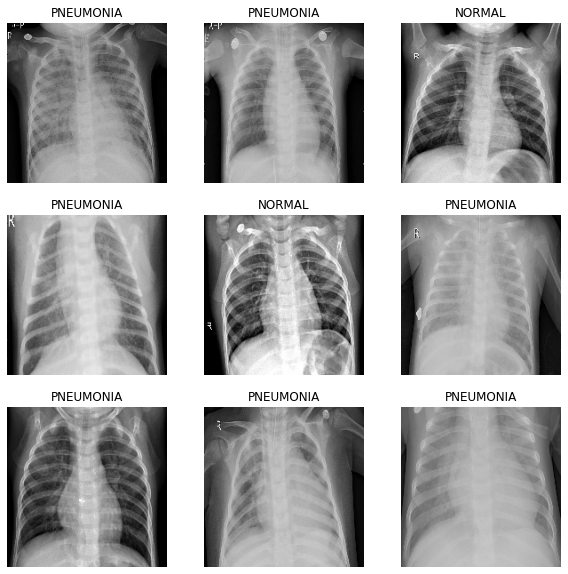

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Image Data Augmentation**

In [17]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.05)
    ]
)

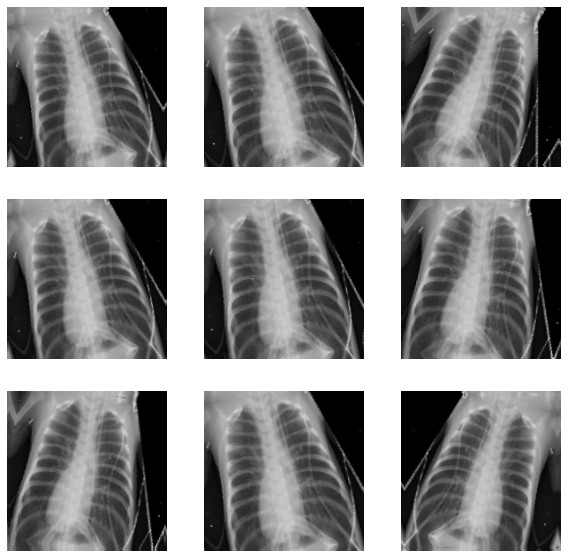

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## **Configure the dataset for performance**

In [19]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# **Build Model**

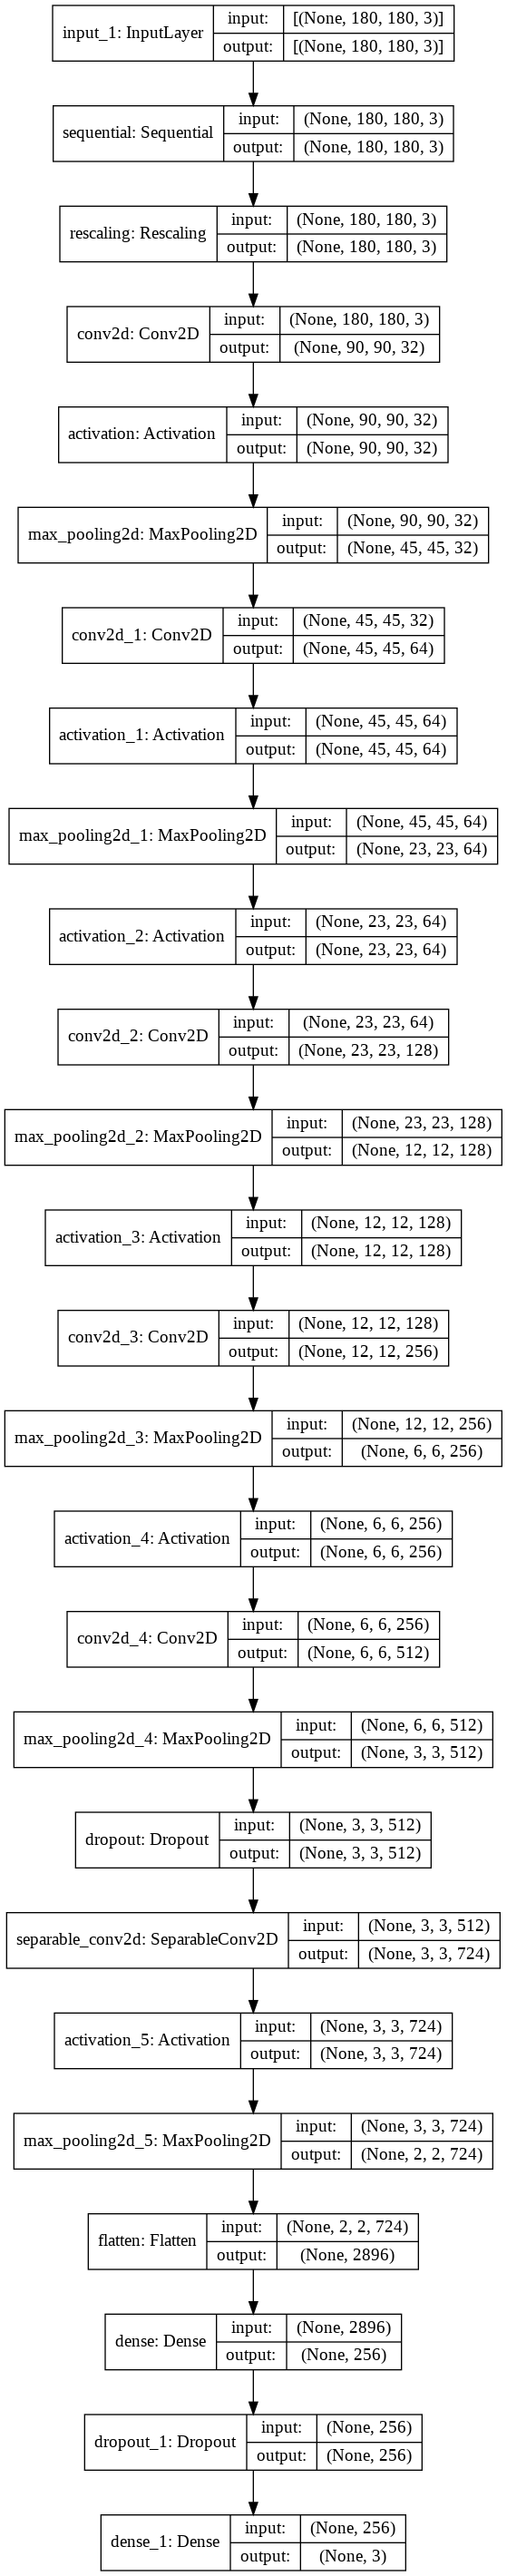

In [20]:
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

# **Train the Model**

In [21]:
checkpoint_filepath = '/content/content'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.01)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [22]:
epochs = 50

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

model.fit(
    train_ds, epochs = epochs, 
    callbacks = [model_checkpoint_callback, early_stop, lr_callback],
    validation_data = val_ds)

Epoch 1/50
129/129 [==============================] - 35s 129ms/step - loss: 0.8819 - accuracy: 0.6567 - val_loss: 0.7691 - val_accuracy: 0.6673
Epoch 2/50
129/129 [==============================] - 21s 156ms/step - loss: 0.6767 - accuracy: 0.7009 - val_loss: 0.4554 - val_accuracy: 0.8113
Epoch 3/50
129/129 [==============================] - 21s 154ms/step - loss: 0.5256 - accuracy: 0.7750 - val_loss: 0.3897 - val_accuracy: 0.8580
Epoch 4/50
129/129 [==============================] - 21s 154ms/step - loss: 0.4349 - accuracy: 0.8280 - val_loss: 0.3383 - val_accuracy: 0.8794
Epoch 5/50
129/129 [==============================] - 21s 154ms/step - loss: 0.3410 - accuracy: 0.8729 - val_loss: 0.2364 - val_accuracy: 0.9076
Epoch 6/50
129/129 [==============================] - 21s 155ms/step - loss: 0.2748 - accuracy: 0.9018 - val_loss: 0.2767 - val_accuracy: 0.9202
Epoch 7/50
129/129 [==============================] - 21s 155ms/step - loss: 0.2511 - accuracy: 0.9106 - val_loss: 0.2009 - val_ac

Text(0.5, 0, 'epoch')

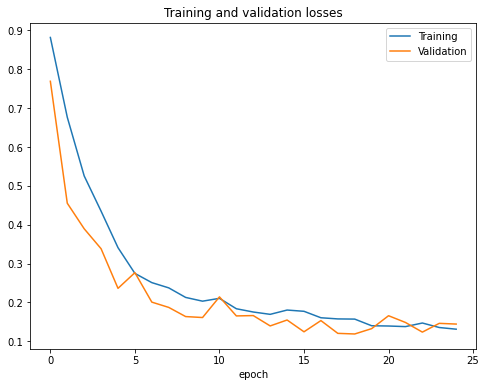

In [23]:
#plot graph between training and validation loss
plt.figure(figsize=(8,6))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and validation losses')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

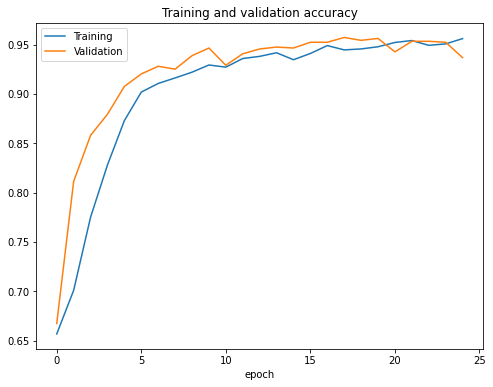

In [24]:
#plot graph between training and validation loss
plt.figure(figsize=(8,6))
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')

In [25]:
tf.keras.models.save_model(
    model,
    "/content/drive/MyDrive/Projects/COVID_CNN/covid_pneum_model2",
    overwrite=True,
    include_optimizer=True,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/COVID_CNN/covid_pneum_model2/assets


In [26]:
# restored_model = tf.keras.models.load_model(
#     "/content/drive/MyDrive/Projects/COVID_CNN/covid_pneum_model2", custom_objects=None, compile=True, options=None
# )

In [27]:
image_path = "/content/Data/test/COVID19/COVID19(469).jpg"

img = keras.preprocessing.image.load_img(
    image_path, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to COVID19 with a 57.61 percent confidence.


In [28]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for filename in uploaded.keys():
  img_path = '/content/'+filename
  img = image.load_img(img_path, target_size=image_size)
  img_array = image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Saving COVID19(461).jpg to COVID19(461).jpg
Saving COVID19(469).jpg to COVID19(469).jpg
Saving NORMAL(1266).jpg to NORMAL(1266).jpg
Saving NORMAL(1267).jpg to NORMAL(1267).jpg
Saving PNEUMONIA(3418).jpg to PNEUMONIA(3418).jpg
Saving PNEUMONIA(3419).jpg to PNEUMONIA(3419).jpg
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 54.50 percent confidence.
This image most likely belongs to NORMAL with a 57.59 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.38 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.57 percent confidence.
